IMPORTING INPUT FROM DRIVE

In [ ]:
!pip install pennylane --upgrade
from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, Model

LOADING INPUT

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train_fetus_75_spanish.xls',header=0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/train_fetus_75_spanish.xls'

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/test_75_spanish (2).xls',header=0)

In [ ]:
 train_df.shape ,  test_df.shape

((9194, 50177), (3061, 50177))

In [ ]:
# Separate features and labels for training data
X1_train = train_df.iloc[:, :-1].values
y1_train = train_df.iloc[:, -1].values
# Separate features and labels for testing data
X1_test = test_df.iloc[:, :-1].values
y1_test = test_df.iloc[:, -1].values

In [ ]:
# Assuming y_resampled contains your class labels
unique, counts = np.unique(y1_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution before augmentation:", class_distribution)

# Identify the minority class
minority_class_label = min(class_distribution, key=class_distribution.get)
print("Minority class label:", minority_class_label)

Class distribution before augmentation: {np.int64(0): np.int64(532), np.int64(1): np.int64(1289), np.int64(2): np.int64(780), np.int64(3): np.int64(1219), np.int64(4): np.int64(3160), np.int64(5): np.int64(2214)}
Minority class label: 0


In [ ]:
X1_train = X1_train / 255.0
X1_test = X1_test / 255.0

In [ ]:
x1_train = X1_train.reshape(9194,224,224)
x1_test = X1_test.reshape(3061,224,224)

In [ ]:
x1_train.shape,x1_test.shape

In [ ]:
x1_train = x1_train.astype(np.float32)
x1_test = x1_test.astype(np.float32)

X1_train = np.repeat(x1_train[..., np.newaxis], 3, axis=-1)
X1_test = np.repeat(x1_test[..., np.newaxis], 3, axis=-1)


X1_train.shape, X1_test.shape   # Repeat grayscale images to create 3 channels

**BACKBONE-Mobilenet **

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras import layers, models, applications, callbacks, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

# ================================
# Base Model (MobileNet)
# ================================
base_model = applications.MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Fine-tune last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ================================
# Classification Head
# ================================
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
features = layers.Dense(28 * 28, activation="relu")(x)
features = layers.Reshape((28, 28, 1))(features)
x = layers.Flatten()(features)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)

# Full model
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ================================
# Callbacks
# ================================
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=False
)
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# ================================
# Class Weights
# ================================
class_labels = np.unique(y1_train)
class_weights = compute_class_weight(
    class_weight='balanced', classes=class_labels, y=y1_train
)
class_weight_dict = dict(zip(class_labels, class_weights))
print("Class weights:", class_weight_dict)

# ================================
# Train
# ================================
history = model.fit(
    X1_train, y1_train,
    epochs=100,
    batch_size=64,
    validation_data=(X1_test, y1_test),
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler, early_stopping]
)

# ================================
# Feature Extraction
# ================================
feature_extractor = models.Model(inputs=base_model.input, outputs=features)

X1_train_features = feature_extractor.predict(X1_train)
X1_test_features = feature_extractor.predict(X1_test)

# Normalize
X1_train_normalized = X1_train_features / np.max(
    X1_train_features, axis=(1, 2, 3), keepdims=True
)
X1_test_normalized = X1_test_features / np.max(
    X1_test_features, axis=(1, 2, 3), keepdims=True
)

# Save extracted features
np.save("/content/drive/MyDrive/X1_train_features.npy", X1_train_normalized)
np.save("/content/drive/MyDrive/X1_test_features.npy", X1_test_normalized)

print("X_train_features shape:", X1_train_normalized.shape)
print("X_test_features shape:", X1_test_normalized.shape)

# ================================
# Evaluation
# ================================
test_loss, test_accuracy = model.evaluate(X1_test, y1_test, verbose=1)
print(f"\nFinal Model Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_proba = model.predict(X1_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y1_test

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# Specificity
specificity_scores = []
cm = confusion_matrix(y_true, y_pred)
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity = tn / (tn + fp + 1e-10)
    specificity_scores.append(specificity)
specificity_macro = np.mean(specificity_scores)

print("\nFinal Metrics:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity_macro)
print("Cohen's Kappa:", kappa)
print("Matthews Corrcoef:", mcc)

# ================================
# Save Results
# ================================
results_summary = {
    "training_history": history.history,
    "final_test_results": {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity_macro,
        "kappa": kappa,
        "mcc": mcc,
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_pred_proba": y_pred_proba.tolist()
    },
    "features": {
        "X1_train_normalized": X1_train_normalized.tolist(),
        "X1_test_normalized": X1_test_normalized.tolist()
    }
}

with open("/content/drive/MyDrive/Mobilenet_results.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print("✅ Features and results summary saved successfully!")


Class weights: {np.int64(0): np.float64(2.880325814536341), np.int64(1): np.float64(1.1887768295836565), np.int64(2): np.float64(1.9645299145299144), np.int64(3): np.float64(1.257041290675417), np.int64(4): np.float64(0.484915611814346), np.int64(5): np.float64(0.6921108099969888)}
Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - accuracy: 0.7183 - loss: 0.7051 - val_accuracy: 0.9056 - val_loss: 0.3085 - learning_rate: 0.0100
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9314 - loss: 0.1563 - val_accuracy: 0.9500 - val_loss: 0.1468 - learning_rate: 0.0100
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9513 - loss: 0.0991 - val_accuracy: 0.9601 - val_loss: 0.1257 - learning_rate: 0.0100
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9686 - loss: 0.0662 - val_accuracy: 0.9418 - val_loss: 0.1557 - learning_rate: 0.0100
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9768 - loss: 0.0479 - val_accur

**Extracted mobilenet output**

In [ ]:
X_train_final = np.load('/content/drive/MyDrive/x_test_final90 (1).npy')
X_test_final = np.load('/content/drive/MyDrive/x_train_final90 (1).npy')    # shape (n_test, 28, 28, 1)
#Y_train = np.load('sp/y_train_75  .npy')
#Y_test = np.load('sp/y_test_75  .npy')    # shape (n_test, 28, 28, 1)

In [ ]:
X_train_final.shape,X_test_final.shape

((9194, 14, 14, 4), (3061, 14, 14, 4))

Extracted mobilenet deep features passed to HQ-
CNN-SA Proposed model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import register_keras_serializable
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, cohen_kappa_score, matthews_corrcoef
)
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

# ======================================================
# Register custom spatial attention
# ======================================================
@register_keras_serializable()
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(
            1, kernel_size, padding='same',
            activation='sigmoid', kernel_initializer='he_normal'
        )

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_out = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        return inputs * self.conv(concat)

# ======================================================
# Define the CNN model with attention
# ======================================================
def improved_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = SpatialAttention()(x)
    x = SpatialAttention()(x)

    x = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ======================================================
# Input shape
# ======================================================
input_shape = (14, 14, 4)

# Compute class weights
class_labels = np.unique(y1_train)
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y1_train)
class_weight_dict = dict(zip(class_labels, class_weights))
print("Class Weights:", class_weight_dict)

# Create and compile the model
model = improved_cnn_model(input_shape)
model.compile(
    optimizer=optimizers.Adagrad(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# ======================================================
# Callbacks (no ModelCheckpoint, no best weights restore)
# ======================================================
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=False,   # keep final weights only
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=5e-8,
    verbose=1
)

# ======================================================
# Data augmentation
# ======================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ======================================================
# Training
# ======================================================
print("Starting training...")
start_time = time.time()

history_mobilenet = model.fit(
    train_datagen.flow(X_train_final, y1_train, batch_size=64),
    epochs=100,
    validation_data=(X_test_final, y1_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# ======================================================
# Evaluate final model (last epoch weights)
# ======================================================
test_loss, test_accuracy = model.evaluate(X_test_final, y1_test, verbose=1)
print(f"\nFinal Model Test Accuracy: {test_accuracy * 100:.2f}%")

# ======================================================
# Predictions using FINAL model
# ======================================================
y_pred_proba = model.predict(X_test_final)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y1_test

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# Specificity (macro)
specificity_scores = []
cm = confusion_matrix(y_true, y_pred)
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity = tn / (tn + fp + 1e-10)
    specificity_scores.append(specificity)
specificity_macro = np.mean(specificity_scores)

print("\nFinal Metrics:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity_macro)
print("Cohen's Kappa:", kappa)
print("Matthews Corrcoef:", mcc)
results_summary = {
    "training_history": history_mobilenet.history,
    "final_test_results": {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity_macro,
        "kappa": kappa,
        "mcc": mcc,
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_pred_proba": y_pred_proba.tolist()
    }
}

with open("/content/drive/MyDrive/Mobile_Q_CNN_final.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print("✅ Results summary saved to sp/mobilenet.pkl")


Class Weights: {np.int32(0): np.float64(2.880325814536341), np.int32(1): np.float64(1.1887768295836565), np.int32(2): np.float64(1.9645299145299144), np.int32(3): np.float64(1.257041290675417), np.int32(4): np.float64(0.484915611814346), np.int32(5): np.float64(0.6921108099969888)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 14, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 14, 14, 512)    │            99 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention_1             │ (None, 14, 14, 512)    │            99 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 7, 7, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,664,332 (116.98 MB)

 Trainable params: 30,661,388 (116.96 MB)

 Non-trainable params: 2,944 (11.50 KB)

Starting training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.7241 - loss: 0.6748 - val_accuracy: 0.5691 - val_loss: 1.6030 - learning_rate: 0.0100
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9765 - loss: 0.0633 - val_accuracy: 0.6939 - val_loss: 0.7607 - learning_rate: 0.0100
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9823 - loss: 0.0427 - val_accuracy: 0.9138 - val_loss: 0.2594 - learning_rate: 0.0100
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9891 - loss: 0.0289 - val_accuracy: 0.9523 - val_loss: 0.2034 - learning_rate: 0.0100
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9878 - loss: 0.0270 - val_accuracy: 0.9432 - val_loss: 0.2716 - learning_rate: 0.0100
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9877 - loss: 0.0348 - val_accuracy: 0.8889 - val_loss: 0.5106 - learning_rate: 0.0100
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9898 - loss: 0.02

comparison with other backbone models

**VGG-19-backbone**

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    precision_score, recall_score, f1_score, cohen_kappa_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

# -----------------------
# 1. Define number of classes
# -----------------------
num_classes = len(np.unique(y1_train))   # ensure y1_train is loaded

# -----------------------
# 2. Base Model: VGG19
# -----------------------
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze all layers except block5
for layer in base_model.layers:
    if "block5" not in layer.name:
        layer.trainable = False

# -----------------------
# 3. Feature Extraction (GAP -> Dense(28*28) -> Reshape)
# -----------------------
x = layers.GlobalAveragePooling2D()(base_model.output)
features = layers.Dense(28*28, activation="relu")(x)      # project to 784 dims
features = layers.Reshape((28,28,1))(features)            # reshape like an image

# Classification head
f = layers.Flatten()(features)
f = layers.Dense(512, activation="relu")(f)
f = layers.Dropout(0.5)(f)
output = layers.Dense(num_classes, activation="softmax")(f)

model = models.Model(inputs=base_model.input, outputs=output)

# -----------------------
# 4. Compile
# -----------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# 5. Callbacks
# -----------------------
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=False),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=5e-8)
]

# -----------------------
# 6. Train
# -----------------------
history_VGG_19 = model.fit(
    X1_train, y1_train,
    validation_data=(X1_test, y1_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)

# -----------------------
# 7. Evaluation
# -----------------------
test_loss, test_accuracy = model.evaluate(X1_test, y1_test, verbose=0)

y_pred_proba = model.predict(X1_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y1_test

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# Specificity (macro)
specificity_scores = []
cm = confusion_matrix(y_true, y_pred)
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity = tn / (tn + fp + 1e-10)
    specificity_scores.append(specificity)
specificity_macro = np.mean(specificity_scores)

print("\nFinal Metrics:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity_macro)
print("Cohen's Kappa:", kappa)
print("Matthews Corrcoef:", mcc)

# -----------------------
# 8. Save extracted reshaped features (DenseNet-style)
# -----------------------
feature_extractor = models.Model(inputs=base_model.input, outputs=features)

X1_train_features_VGG_19 = feature_extractor.predict(X1_train, batch_size=64, verbose=1)
X1_test_features_VGG_19  = feature_extractor.predict(X1_test, batch_size=64, verbose=1)

np.save("/content/drive/MyDrive/vgg19_train_features.npy", X1_train_features_VGG_19)
np.save("/content/drive/MyDrive/vgg19_test_features.npy", X1_test_features_VGG_19)

# -----------------------
# 9. Save results summary
# -----------------------
results_summary = {
    "training_history": history_VGG_19.history,
    "final_test_results": {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity_macro,
        "kappa": kappa,
        "mcc": mcc,
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_pred_proba": y_pred_proba.tolist()
    }
}

with open("/content/drive/MyDrive/vgg19_results.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print("✅ VGG19 DenseNet-style features & results saved to Drive")


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 263ms/step - accuracy: 0.6381 - loss: 0.9701 - val_accuracy: 0.9330 - val_loss: 0.2212 - learning_rate: 1.0000e-04
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.9055 - loss: 0.2773 - val_accuracy: 0.9278 - val_loss: 0.1914 - learning_rate: 1.0000e-04
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.9339 - loss: 0.1817 - val_accuracy: 0.9409 - val_loss: 0.1664 - learning_rate: 1.0000e-04
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.9537 - loss: 0.1391 - val_accuracy: 0.9445 - val_loss: 0.1643 - learning_rate: 1.0000e-04
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.9645 - loss: 0.1084 - val_accuracy: 0.9389 - val_loss: 0.2097 - learning_rate: 1.0000e-04
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.9660 - loss: 0.0985 - val_accuracy: 0.9435 - val_loss: 0.1788 - learning_rate: 1.0000e-04
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 20

**Densenet 121-QCNN**

In [ ]:
x_train_final  = np.load('/content/drive/MyDrive/x_train_final_densenet_QCNN.npy')
x_test_final = np.load('/content/drive/MyDrive/x_test_final_densenetnet_QCNN.npy')    # shape (n_test, 28, 28, 1)

In [ ]:
Densenet 121-

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score, recall_score, f1_score, cohen_kappa_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

# -----------------------
# Parameters
# -----------------------
input_shape = (224, 224, 3)
num_classes = 6
batch_size = 64
epochs = 30  # train directly with fine-tuning

# -----------------------
# Labels check
# -----------------------
print("y1_train shape:", y1_train.shape)
print("Unique labels in train:", np.unique(y1_train))

# -----------------------
# Compute class weights
# -----------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y1_train),
    y=y1_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# -----------------------
# Base DenseNet model
# -----------------------
base_model = applications.DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Unfreeze last Dense block for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# -----------------------
# Feature Extraction + Reshape
# -----------------------
x = layers.GlobalAveragePooling2D()(base_model.output)
features = layers.Dense(28 * 28, activation="relu")(x)   # project to 784 dims
features = layers.Reshape((28, 28, 1))(features)         # reshape like image

# Classification head
f = layers.Flatten()(features)
f = layers.Dense(512, activation="relu")(f)
f = layers.Dropout(0.5)(f)
output = layers.Dense(num_classes, activation="softmax")(f)

model = models.Model(inputs=base_model.input, outputs=output)

# -----------------------
# Compile model
# -----------------------
model.compile(
    optimizer=optimizers.Adagrad(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# Callbacks
# -----------------------
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=False
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

# -----------------------
# Train (only fine-tuning phase)
# -----------------------
history1 = model.fit(
    X1_train, y1_train,
    validation_data=(X1_test, y1_test),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# -----------------------
# Evaluation
# -----------------------
test_loss, test_accuracy = model.evaluate(X1_test, y1_test, verbose=0)

y_pred_proba = model.predict(X1_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y1_test

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# Specificity (macro)
specificity_scores = []
cm = confusion_matrix(y_true, y_pred)
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity = tn / (tn + fp + 1e-10)
    specificity_scores.append(specificity)
specificity_macro = np.mean(specificity_scores)

print("\nFinal Metrics:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity_macro)
print("Cohen's Kappa:", kappa)
print("Matthews Corrcoef:", mcc)

# -----------------------
# Save extracted features
# -----------------------
feature_extractor = models.Model(inputs=base_model.input, outputs=features)

X1_train_features = feature_extractor.predict(X1_train, batch_size=batch_size)
X1_test_features = feature_extractor.predict(X1_test, batch_size=batch_size)

np.save("/content/drive/MyDrive/densenet121_train_features.npy", X1_train_features)
np.save("/content/drive/MyDrive/densenet121_test_features.npy", X1_test_features)

# -----------------------
# Save results
# -----------------------
results_summary = {
    "training_history": history1.history,
    "final_test_results": {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity_macro,
        "kappa": kappa,
        "mcc": mcc,
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_pred_proba": y_pred_proba.tolist()
    }
}

with open("/content/drive/MyDrive/densenet121_results.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print("✅ Features & results saved to Drive")


y1_train shape: (9194,)
Unique labels in train: [0 1 2 3 4 5]
Class weights: {0: np.float64(2.880325814536341), 1: np.float64(1.1887768295836565), 2: np.float64(1.9645299145299144), 3: np.float64(1.257041290675417), 4: np.float64(0.484915611814346), 5: np.float64(0.6921108099969888)}
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 92s 397ms/step - accuracy: 0.6171 - loss: 1.1732 - val_accuracy: 0.8997 - val_loss: 0.2724 - learning_rate: 0.0400
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.8868 - loss: 0.2758 - val_accuracy: 0.8634 - val_loss: 0.3733 - learning_rate: 0.0400
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9177 - loss: 0.1723 - val_accuracy: 0.9363 - val_loss: 0.1882 - learning_rate: 0.0400
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9335 - loss: 0.1442 - val_accuracy: 0.9196 - val_loss: 0.2249 - learning_rate: 0.0400
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/st

In [ ]:
resnet-50

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score, recall_score, f1_score, cohen_kappa_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

# -----------------------
# Parameters
# -----------------------
input_shape = (224, 224, 3)
num_classes = 6
batch_size = 64
epochs = 20  # adjust as needed

# -----------------------
# Labels check
# -----------------------
print("y1_train shape:", y1_train.shape)
print("Unique labels in train:", np.unique(y1_train))

# -----------------------
# Compute class weights
# -----------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y1_train),
    y=y1_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# -----------------------
# Base ResNet50 model
# -----------------------
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Freeze ~60% of layers, fine-tune last ~40%
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.6)
print(f"Total layers: {total_layers}, Freezing until: {freeze_until}")

for i, layer in enumerate(base_model.layers[:freeze_until]):
    layer.trainable = False
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

# -----------------------
# Custom Head
# -----------------------
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output)

# -----------------------
# Compile model
# -----------------------
model.compile(
    optimizer=optimizers.Adagrad(learning_rate=0.01),  # Adam + smaller LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# -----------------------
# Callbacks
# -----------------------
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=5e-8
)

# -----------------------
# Train
# -----------------------
history_resnet = model.fit(
    X1_train, y1_train,
    validation_data=(X1_test, y1_test),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# -----------------------
# Evaluation
# -----------------------
test_loss, test_accuracy = model.evaluate(X1_test, y1_test, verbose=0)

y_pred_proba = model.predict(X1_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y1_test

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

# Specificity (macro)
specificity_scores = []
cm = confusion_matrix(y_true, y_pred)
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity = tn / (tn + fp + 1e-10)
    specificity_scores.append(specificity)
specificity_macro = np.mean(specificity_scores)

print("\nFinal Metrics:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity_macro)
print("Cohen's Kappa:", kappa)
print("Matthews Corrcoef:", mcc)

# -----------------------
# Save results
# -----------------------
results_summary = {
    "training_history": history_resnet.history,
    "final_test_results": {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "specificity": specificity_macro,
        "kappa": kappa,
        "mcc": mcc,
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report,
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "y_pred_proba": y_pred_proba.tolist()
    }
}

with open("/content/drive/MyDrive/resnet50_tuned.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print("✅ Results summary saved to sp/resnet50_tuned.pkl")


y1_train shape: (9194,)
Unique labels in train: [0 1 2 3 4 5]
Class weights: {0: np.float64(2.880325814536341), 1: np.float64(1.1887768295836565), 2: np.float64(1.9645299145299144), 3: np.float64(1.257041290675417), 4: np.float64(0.484915611814346), 5: np.float64(0.6921108099969888)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total layers: 175, Freezing until: 105
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 75s 345ms/step - accuracy: 0.4381 - loss: 1.3868 - val_accuracy: 0.1542 - val_loss: 10.8693 - learning_rate: 0.0100
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.7163 - loss: 0.6520 - val_accuracy: 0.4796 - val_loss: 1.5093 - learning_rate: 0.0100
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.7827 - loss: 0.5104 - val_accuracy: 0.4646 - val_loss: 2.0085 - learning_rate: 0.0100
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.8256 - loss: 0.4164 - val_accuracy: 0.6197 - val_loss: 0.9541 - learning_rate: 0.0100
Epoc

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.manifold import TSNE

# ---------------------------
# Load saved results
# ---------------------------
with open("/content/drive/MyDrive/Mobile_Q_CNN_final.pkl", "rb") as f:
    results_summary = pickle.load(f)

history = results_summary["training_history"]
final_results = results_summary["final_test_results"]

# Extract values
y_true = np.array(final_results["y_true"])
y_pred = np.array(final_results["y_pred"])
y_pred_proba = np.array(final_results["y_pred_proba"])
conf_matrix = np.array(final_results["confusion_matrix"])

class_names = ["Abdomen", "Thorax", "Femur", "Cervix", "Other", "Brain"]

# ---------------------------
# 1. Confusion Matrix
# ---------------------------
plt.figure(figsize=(6,6), dpi=300)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap="Greys", values_format="d", xticks_rotation=45)
#plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("confusion_matrix.jpg", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 2. ROC Curve + AUC
# ---------------------------
n_classes = y_pred_proba.shape[1]
plt.figure(figsize=(7,7), dpi=300)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2.5, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--', linewidth=2)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
#plt.title("ROC Curve", fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("roc_curve.jpg", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 3. t-SNE visualization
# ---------------------------
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(y_pred_proba)

plt.figure(figsize=(7,7), dpi=300)
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_true, cmap="tab10", alpha=0.7, s=50)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes", fontsize=10)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
#plt.title("t-SNE Visualization", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("tsne_visualization.jpg", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 4. Accuracy & Loss Plots
# ---------------------------
plt.figure(figsize=(14,5), dpi=300)

# Accuracy
plt.subplot(1,2,1)
plt.plot(history["accuracy"], label="Train Acc", linewidth=2.5)
plt.plot(history["val_accuracy"], label="Val Acc", linewidth=2.5)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
#plt.title("Training vs Validation Accuracy", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Loss
plt.subplot(1,2,2)
plt.plot(history["loss"], label="Train Loss", linewidth=2.5)
plt.plot(history["val_loss"], label="Val Loss", linewidth=2.5)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
#plt.title("Training vs Validation Loss", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("accuracy_loss.jpg", dpi=300, bbox_inches="tight")
plt.show()


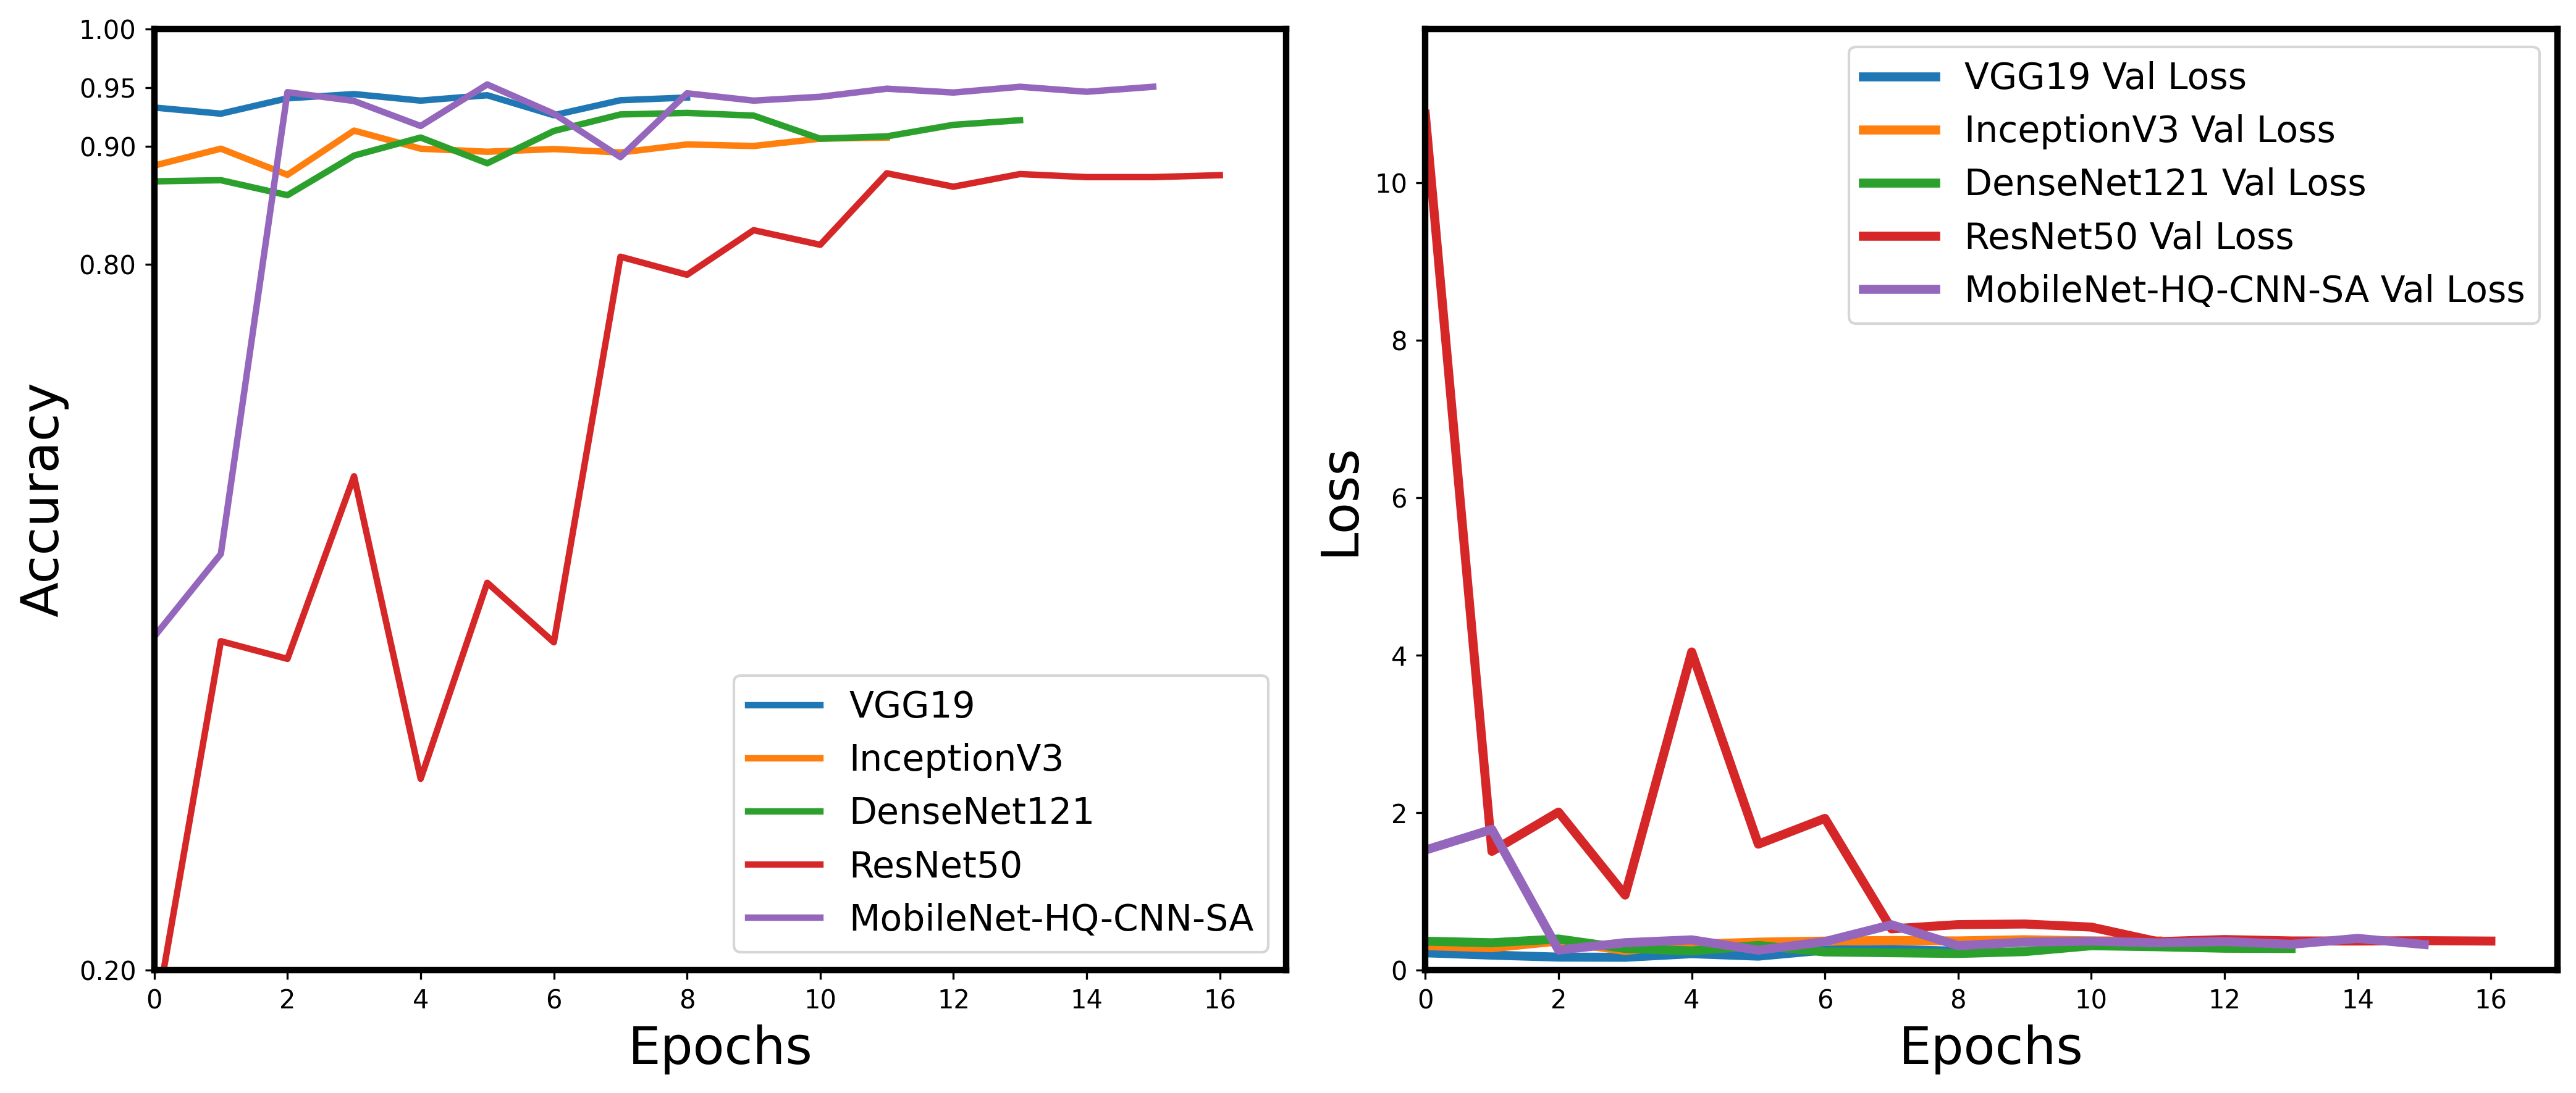

In [ ]:
import pickle
import matplotlib.pyplot as plt

# ---------------------------
# Load Results
# ---------------------------
paths = {
    "VGG19": "/content/drive/MyDrive/vgg19_results.pkl",
    "InceptionV3": "/content/drive/MyDrive/Results/inception/Inception_results.pkl",
    "DenseNet121": "/content/drive/MyDrive/Results/Densenet/dense_dL/densenet121_results.pkl",
    "ResNet50": "/content/drive/MyDrive/Results/Resnet-50/resnet -50/resnet50_tuned.pkl",
    "MobileNet-HQ-CNN-SA": "/content/drive/MyDrive/Results/mobilenet/Mobile_net_QCNN/Mobile_Q_CNN_final.pkl"
}

histories = {}

for model_name, path in paths.items():
    with open(path, "rb") as f:
        summary = pickle.load(f)
    histories[model_name] = summary["training_history"]

# ---------------------------
# Validation Accuracy & Loss Comparison
# ---------------------------
plt.figure(figsize=(14, 6), dpi=300)

# Validation Accuracy
ax1 = plt.subplot(1, 2, 1)
for model_name, history in histories.items():
    plt.plot(history["val_accuracy"], label=f"{model_name}", linewidth=2.5)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend(fontsize=14)
plt.grid(False)
plt.xlim(0, max(len(h["val_accuracy"]) for h in histories.values()))
plt.ylim(0.2, 1.0)  # start at 0.2, full till 1.0
plt.yticks([0.2, 0.8, 0.9, 0.95, 1.0])

# Thicken borders
for spine in ax1.spines.values():
    spine.set_linewidth(2.5)

# Validation Loss
ax2 = plt.subplot(1, 2, 2)
for model_name, history in histories.items():
    plt.plot(history["val_loss"], label=f"{model_name} Val Loss", linewidth=3.5)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize=14)
plt.grid(False)
plt.xlim(0, max(len(h["val_loss"]) for h in histories.values()))
plt.ylim(0, max(max(h["val_loss"]) for h in histories.values()) * 1.1)

# Thicken borders
for spine in ax2.spines.values():
    spine.set_linewidth(2.5)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Results/model_comparison.jpg", dpi=300, format="jpg")
plt.show()


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef,
    confusion_matrix
)

# ---------------------------
# Paths to result files
# ---------------------------
paths = {
    "InceptionV3": "/content/drive/MyDrive/Results/inception/Inception_results.pkl",
    "DenseNet121": "/content/drive/MyDrive/Results/Densenet/dense_dL/densenet121_results.pkl",
    "ResNet50": "/content/drive/MyDrive/Results/Resnet-50/resnet -50/resnet50_tuned.pkl"
}

# ---------------------------
# Function to calculate metrics
# ---------------------------
def compute_metrics(y_true, y_pred):
    # Convert probabilities to class labels if needed
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    # Specificity (TN / (TN+FP)) → averaged across classes
    cm = confusion_matrix(y_true, y_pred)
    TN = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    FP = cm.sum(axis=0) - np.diag(cm)
    specificity = np.mean(TN / (TN + FP))

    return accuracy, precision, recall, f1, specificity, kappa, mcc

# ---------------------------
# Process each model
# ---------------------------
results = {}

for model_name, path in paths.items():
    with open(path, "rb") as f:
        data = pickle.load(f)

    # Access inside "final_test_results"
    y_true = np.array(data["final_test_results"]["y_true"])
    y_pred = np.array(data["final_test_results"]["y_pred"])

    metrics = compute_metrics(y_true, y_pred)
    results[model_name] = metrics

# ---------------------------
# Display Results
# ---------------------------
df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score", "Specificity", "Cohen Kappa", "MCC"]).T
print(df)


             Accuracy  Precision    Recall  F1-score  Specificity  \
InceptionV3  0.907547   0.890188  0.899932  0.893104     0.980538   
DenseNet121  0.922248   0.915948  0.916023  0.914471     0.983248   
ResNet50     0.877491   0.864237  0.895029  0.869866     0.975434   

             Cohen Kappa       MCC  
InceptionV3     0.881478  0.881910  
DenseNet121     0.900088  0.900297  
ResNet50        0.845078  0.848722  
